In [1]:
from Utils import *

import re

# data_root = './Anonymized_644.Updated_cleaned_v1.3.2.tsv'
data_root = './anonymized_644.csv'
adjacency_file = './connectivity_646.csv'
cluster_root = 'ln_Data_and_clusters.csv'
validation_file = 'validation_data.xlsx'
radiomic_cluster_file = 'hp_updated_clusters.csv'

In [2]:
def read_radiomic_clusters(radiomic_file = 'hp_updated_clusters.csv'):
    radiomic_file_dict = {
        'Dummy.ID': 'id',
        'T.category': 'T-category',
        'N.cat': 'N-category',
        'AJCC.8': 'ajcc8',
        'radScoreClusterOS3': 'rad_cluster'
    }
    return pd.read_csv(radiomic_file).rename(radiomic_file_dict,axis=1).loc[:,:].set_index('id')
test = read_radiomic_clusters()
for rnl, d in test.groupby('RLN'):
    print(rnl, d.shape)

1 (310, 14)
2 (575, 14)
3 (98, 14)


In [3]:
def mutual_cols(df1,df2):
    cols1 = set(df1.columns)
    cols2 = set(df2.columns)
    return list(cols1.intersection(cols2))

def drop_duplicate_index(df):
    index_name = df.index.name
    return df.reset_index().drop_duplicates(subset=index_name,keep='first').set_index(index_name)

def print_counts(df, col):
    for c, d in df.groupby(col):
        print(col,c,':',d.shape[0])
        
def combined_risk_cluster(row, ln_clust='ln_cluster', rad_clust='rad_cluster'):
    rad_c = row[rad_clust] - 1
    ln_c = np.abs(row[ln_clust]) - 1
    risk = ln_c + rad_c
    if risk >= 3:
        return 3
    elif risk > 0:
        return 2
    else:
        return 1

def load_and_merge_validation_clusters():
    ln_name = 'cluster_euclidean_average'
    rad_name = 'rad_cluster'
    
    rad_clusters = read_radiomic_clusters()
    
    val_clusters = pd.read_csv('validation_clusters.csv').set_index('id')
    
    iset = lambda d: set(d.index.values.tolist())
    print(iset(rad_clusters) - iset(val_clusters))
    
    val_clusters = val_clusters.merge(rad_clusters, on='id').rename({ln_name:'ln_cluster',rad_name:'rad_cluster'},axis=1)
    val_clusters = val_clusters.loc[:,['ln_cluster']+list(rad_clusters.columns)]
    val_clusters.loc[:,'combined_cluster'] = val_clusters['RLN'] #val_clusters.apply(combined_risk_cluster,axis=1)
    return drop_duplicate_index(val_clusters)

val_clusters = load_and_merge_validation_clusters()
print_counts(val_clusters,'combined_cluster')
print(val_clusters.shape)
for c,d in val_clusters.reset_index().groupby('id'):
    if d.shape[0] > 1:
        print(d)
val_clusters.T

set()
combined_cluster 1 : 310
combined_cluster 2 : 575
combined_cluster 3 : 98
(983, 16)


id,1,5064,5063,5062,5059,5057,5056,5055,5053,5050,...,10132,10136,10145,10148,10154,10165,10184,10196,10200,10201
ln_cluster,1,1,1,1,1,1,1,1,1,1,...,-1,-1,-1,1,-1,-1,1,-1,1,-1
Unnamed: 0,584,419,418,266,374,265,362,630,417,590,...,6,84,7,11,8,9,555,565,13,10
HPV.P16.status,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,...,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
T-category,T1,T1,T2,T1,T2,T2,T2,T1,T2,T1,...,T2,T2,T2,T3,T3,T3,T4,T2,T2,T4
N-category,N1,N1,N1,N1,N1,N1,N1,N1,N1,N1,...,N0,N2,N0,N0,N0,N0,N0,N0,N0,N0
ajcc8,1,1,1,1,1,1,1,1,1,1,...,2,4,2,3,3,3,4,2,2,4
site,Tonsil,BOT,BOT,BOT,Tonsil,Tonsil,Tonsil,BOT,BOT,Other,...,Tonsil,Tonsil,Tonsil,BOT,BOT,Tonsil,Tonsil,BOT,BOT,BOT
white,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,1,1,1,1
smoke,Current,Former,Never,Former,Never,Never,Current,Former,Never,Never,...,Former,Never,Current,Never,Current,Current,Never,Never,Current,Former
age,57.019444,57.211111,56.447222,85.638889,65.347222,42.155556,57.352778,63.647222,60.05,42.775,...,58.533333,52.372222,75.95,65.808333,72.158333,77.588889,63.130556,73.241667,59.363889,66.616667


In [4]:
def merge_val_cluster_values(df, val_clusters, left=['ln_cluster','rad_cluster','combined_cluster']):
    mcols = mutual_cols(df, val_cluster)
    for col in mcols:
        df.loc[val_clusters.index,col] = val_clusters.loc[:,col]
    return df.merge(val_clusters[left],on='id')

In [5]:
def mutual_cols(df1,df2):
    cols1 = set(df1.columns)
    cols2 = set(df2.columns)
    return list(cols1.intersection(cols2))

def merge_val_cluster_values(df, val_clusters, left=['ln_cluster','rad_cluster','combined_cluster']):
    mcols = mutual_cols(df, val_clusters)
    for col in mcols:
        df.loc[val_clusters.index,col] = val_clusters.loc[:,col]
    return df.merge(val_clusters[left],on='id')

def combined_testsets(val_clusts):
    sd = LNDataset(data_root, validation=True)
    
    validation_data = pd.read_excel(validation_file, index_col = 0).rename(columns = {'Affected Lymph node': 'Affected Lymph node UPPER','AJCC stage 8th edition':'ajcc8'})
    vd = LNDataset(validation_data, validation=True)
    
    shared_cols = mutual_cols(sd.data,vd.data)
    pdata = pd.concat([sd.data.loc[:,shared_cols],vd.data.loc[:,shared_cols]])
    
#     pdata = pdata.merge(val_clusts,on='id',how='inner')
    pdata = merge_val_cluster_values(pdata, val_clusts)
    return drop_duplicate_index(pdata)

def combined_grams(val_clusts):
    sd = LNDataset(data_root, validation=True)
    validation_data = pd.read_excel(validation_file, index_col = 0).rename(columns = {'Affected Lymph node': 'Affected Lymph node UPPER'})
    vd = LNDataset(validation_data, validation=True)
    
    grams = pd.concat([sd.bigrams(),vd.bigrams()])#.merge(val_clusts,on='id')
    grams = merge_val_cluster_values(grams, val_clusts)
    return drop_duplicate_index(grams)

pdata = combined_testsets(val_clusters)
grams = combined_grams(val_clusters)
pdata = pdata.merge(grams, on=['id','ln_cluster','rad_cluster','combined_cluster'])
print(pdata.columns)
pdata.T

Index(['smoking_status', 'affected_nodes', 'TOX', 'total_dose', 'T-category',
       'laterality', 'gender', 'neck_boost', 'N-category', 'FT', 'subsite',
       'Aspiration rate Post-therapy', 'AS', 'nodes',
       'Aspiration rate Pre-therapy', 'ajcc8', 'hpv', 'treatment',
       'ln_cluster', 'rad_cluster', 'combined_cluster', '1A1B', '1A6', '1B2A',
       '1B3', '2A2B', '2A3', '2B5A', '34', '35A', '36', '45B', '46', '5A5B',
       'ips_spread', 'contra_spread', '1A', '1B', '2A', '2B', '3', '4', '5A',
       '5B', '6', 'RPLN'],
      dtype='object')


id,1,2,3,4,5,6,7,8,9,10,...,7507,7508,7509,7510,7512,7513,7514,7515,7516,7517
smoking_status,Current,Never,Never,Never,Never,Never,Current,Formar,Never,Never,...,Never,Former,Never,Former,Current,Former,Never,Former,Current,Never
affected_nodes,"R2, R3",R2,"L2, L3",R2,R3,"R2, R3","R2, L3",L2,R2,R3,...,"R2, R3",,L2,R2,"R1b, R2","R2, R3",,"R2, R3",R RPLN,R2
TOX,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
total_dose,66.0,66.0,70.0,66.0,69.96,70.0,69.96,66.0,72.0,69.96,...,70.0,70.0,66.0,70.0,70.0,70.0,70.0,70.0,70.0,70.0
T-category,T1,T2,T2,T1,T4,T1,T4,T1,T3,T3,...,T2,T2,T1,T1,T2,T2,T2,T2,T2,T3
laterality,R,R,L,R,R,R,Bilateral,L,R,R,...,R,R,Bilateral,L,R,R,L,R,R,R
gender,Male,Female,Female,Male,Male,Male,Male,Female,Male,Male,...,Male,Male,Male,Male,Male,Male,Female,Male,Male,Male
neck_boost,N,Y,N,N,N,N,N,Y,Y,N,...,Y,N,Y,Y,Y,Y,N,Y,Y,Y
N-category,N1,N1,N1,N1,N1,N1,N2,N2,N3,N1,...,N1,N0,N1,N2,N1,N1,N1,N1,N1,N1
FT,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [240]:
train_data = pdata.loc[LNDataset(data_root, validation=True).index,:]
train_data.T

/home/evl/andrew/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


id,1,2,3,4,5,6,7,8,9,10,...,10196,10197,10198,10199,10200,10201,10202,10203,10204,10205
affected_nodes,"R2, R3",R2,"L2, L3",R2,R3,"R2, R3","R2, L3",L2,R2,R3,...,,R2,L2,R2,R2,,"R2, R3",R2,R2,R2
gender,Male,Female,Female,Male,Male,Male,Male,Female,Male,Male,...,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male
Aspiration rate Pre-therapy,N,N,N,N,N,N,N,N,N,N,...,N,N,N,N,N,N,N,N,N,N
N-category,N1,N1,N1,N1,N1,N1,N2,N2,N3,N1,...,N0,N0,N2,N1,N0,N0,N2,N2,N2,N1
smoking_status,Current,Never,Never,Never,Never,Never,Current,Formar,Never,Never,...,Never,Formar,Formar,Formar,Current,Formar,Never,Never,Current,Current
Aspiration rate Post-therapy,N,N,N,N,N,N,Y,N,N,N,...,Y,Y,N,N,Y,Y,N,Y,N,Y
laterality,R,R,L,R,R,R,Bilateral,L,R,R,...,R,R,L,R,R,L,R,L,R,Bilateral
ajcc8,1,1,1,1,3,1,3,4,3,2,...,2,3,4,3,2,4,4,4,4,3
FT,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
nodes,"[R2A, R2B, R3]","[R2A, R2B]","[L2A, L2B, L3]","[R2A, R2B]",[R3],"[R2A, R2B, R3]","[L3, R2A, R2B]","[L2A, L2B]","[R2A, R2B]",[R3],...,[],"[R2A, R2B]","[L2A, L2B]","[R2A, R2B]","[R2A, R2B]",[],"[R2A, R2B, R3]","[R2A, R2B]","[R2A, R2B]","[R2A, R2B]"


In [241]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
def red_hex(val, scale = 1):
    return to_hex(plt.get_cmap('Reds')(val**scale))

def purple_hex(val, scale = 1):
    return to_hex(plt.get_cmap('Purples')(val**scale))

def plt_hex(val, colorname, scale = 1):
    return to_hex(plt.get_cmap(colorname)(val**scale))

def cluster_colors(clusters, sd, scale = .5):
    cluster_df = add_outcomes(clusters, sd).merge(sd.dual_monograms, on='id').merge(sd.spread,on='id')
    cluster_df = cluster_df.merge(sd.dual_bigrams, on='id')
    return cluster_df_colors(cluster_df,scale)

def get_node_names():
    names = ['1A', '1B', '2A',
        '2B', '3', '4', '5A', '5B', '6', 'RPLN'
    ]
    return names

def cluster_df_colors(cluster_df, cluster_name, scale = .5):
    map_list = {}
    val_list = {}
    for g,d in cluster_df.groupby(cluster_name):
        node_names = get_node_names()
        unilateral = (d.loc[:,node_names] >= 1).astype('int')
        bilateral = (d.loc[:,node_names]  > 1).astype('int')
        df = pd.concat([unilateral.mean(),bilateral.mean()],axis=1)
        df[['colorleft','colorright']] = df.applymap(lambda x: purple_hex(x, scale))
        map_list[g] =df.copy()
    return map_list

colormap = cluster_df_colors(pdata,'combined_cluster')
for k,v in colormap.items():
    print(k)
    print(v)
    print()

1
             0         1 colorleft colorright
1A    0.000000  0.000000   #fcfbfd    #fcfbfd
1B    0.029032  0.000000   #e8e6f2    #fcfbfd
2A    0.858065  0.000000   #4b1687    #fcfbfd
2B    0.851613  0.003226   #4c1788    #f6f5f9
3     0.419355  0.000000   #7c75b6    #fcfbfd
4     0.090323  0.000000   #cecfe5    #fcfbfd
5A    0.006452  0.000000   #f4f2f8    #fcfbfd
5B    0.006452  0.000000   #f4f2f8    #fcfbfd
6     0.000000  0.000000   #fcfbfd    #fcfbfd
RPLN  0.058065  0.003226   #dcdcec    #f6f5f9

2
             0         1 colorleft colorright
1A    0.012174  0.000000   #f1eff6    #fcfbfd
1B    0.078261  0.006957   #d3d3e8    #f3f2f8
2A    0.888696  0.231304   #481185    #a29fcb
2B    0.883478  0.229565   #491285    #a3a0cb
3     0.436522  0.019130   #7970b3    #edebf4
4     0.109565  0.012174   #c7c8e1    #f1eff6
5A    0.038261  0.003478   #e3e2ef    #f6f4f9
5B    0.029565  0.001739   #e7e6f1    #f8f7fa
6     0.000000  0.000000   #fcfbfd    #fcfbfd
RPLN  0.097391  0.003478   #c

In [242]:
train_colormap = cluster_df_colors(train_data,'ln_cluster')
for k,v in train_colormap.items():
    print(k)
    print(v)
    print()

-1.0
        0    1 colorleft colorright
1A    0.0  0.0   #fcfbfd    #fcfbfd
1B    0.0  0.0   #fcfbfd    #fcfbfd
2A    0.0  0.0   #fcfbfd    #fcfbfd
2B    0.0  0.0   #fcfbfd    #fcfbfd
3     0.0  0.0   #fcfbfd    #fcfbfd
4     0.0  0.0   #fcfbfd    #fcfbfd
5A    0.0  0.0   #fcfbfd    #fcfbfd
5B    0.0  0.0   #fcfbfd    #fcfbfd
6     0.0  0.0   #fcfbfd    #fcfbfd
RPLN  0.0  0.0   #fcfbfd    #fcfbfd

1.0
             0         1 colorleft colorright
1A    0.004264  0.000000   #f5f4f9    #fcfbfd
1B    0.031983  0.000000   #e6e5f1    #fcfbfd
2A    0.946695  0.002132   #430780    #f8f6fa
2B    0.925373  0.000000   #450b82    #fcfbfd
3     0.400853  0.000000   #7e79b8    #fcfbfd
4     0.081023  0.002132   #d2d2e7    #f8f6fa
5A    0.010661  0.000000   #f1f0f6    #fcfbfd
5B    0.006397  0.000000   #f4f2f8    #fcfbfd
6     0.000000  0.000000   #fcfbfd    #fcfbfd
RPLN  0.085288  0.000000   #d0d1e6    #fcfbfd

2.0
             0         1 colorleft colorright
1A    0.000000  0.000000   #fcfbfd   

In [234]:
i = 0
while i <= .75:
    print(plt_hex(i**.5,'BuGn'))
    i += .15

#f7fcfd
#94d6c5
#57ba92
#36a164
#1c8540
#026f2e


cluster 1 count 310 % RAD 0.13870967741935483 color #9ad8ca
cluster 2 count 575 % RAD 0.2852173913043478 color #5cbd98
cluster 3 count 98 % RAD 0.5714285714285714 color #218944


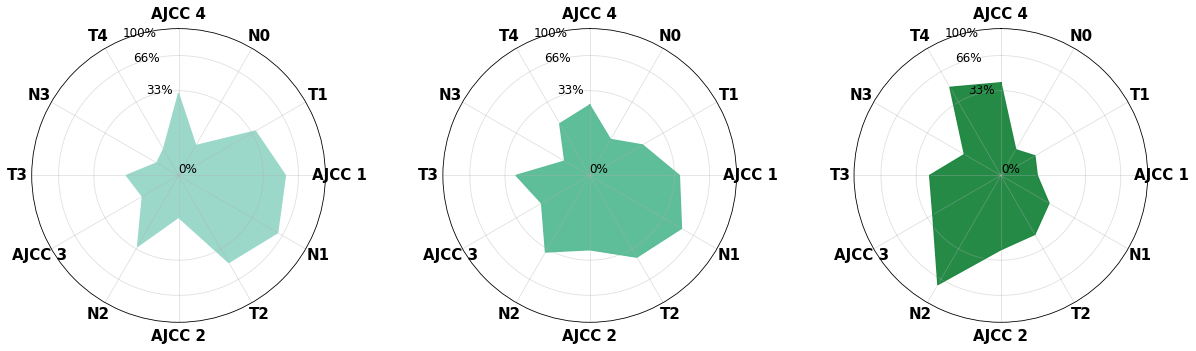

In [247]:
def rank_map(values):
    vals = sorted(set(values))
    rankmap = {}
    for p,val in enumerate(vals):
        rankmap[val] = p
    return rankmap

def validation_radar_outcomes(data,cluster_name):
    discrete = lambda col, x: data.loc[:,col] == x
    def combine(col, varlist):
        discretelist = [discrete(col,x) for x in varlist]
        output = discretelist[0]
        for series in discretelist:
            output = (output + series) > 0
        return output
    cm = data.rename(columns={'TOX':"RAD"})
    cm = cm[[cluster_name,'RAD']]
#     cm['T1'] = sd.data.loc[:,'T-category'] == 'T1'
#     cm['T4'] = sd.data.loc[:,'T-category'] == 'T4'
#     cm['N1'] = sd.data.loc[:,'N-category'] == 'N1'
#     cm['N2a'] = sd.data.loc[:,'N-category'] == 'N2a'
#     cm['N2b'] = sd.data.loc[:,'N-category'] == 'N2b'
#     cm['N2c'] = sd.data.loc[:,'N-category'] == 'N2c'
#     cm['N3'] = sd.data.loc[:,'N-category'] == 'N3'
#     cm['N2c/3'] = (sd.data.loc[:,'N-category'] == 'N3') + (sd.data.loc[:,'N-category'] == 'N2c') > 0
#     cm['70gy'] = sd.data.loc[:,'total_dose'] >= 70
    cm['T1'] = combine('T-category',['T1'])
    cm['T2'] = combine('T-category',['T2'])
    cm['T3'] = combine('T-category',['T3'])
    cm['T4'] = combine('T-category',['T4'])
    cm['N0'] = combine('N-category',['N0'])
    cm['N1'] = combine('N-category',['N1'])
    cm['N2'] = combine('N-category', ['N2','N2a','N2b'])
    cm['N3'] = combine('N-category',['N2c','N3'])
    cm['AJCC 1'] = combine('ajcc8',[1])
    cm['AJCC 2'] = combine('ajcc8',[2])
    cm['AJCC 3'] = combine('ajcc8',[3])
    cm['AJCC 4'] = combine('ajcc8',[4])
    
#     labels = sorted(set(cm.columns) - set([cluster_name,'RAD']))
    labels=['N0','T1','AJCC 1','N1','T2','AJCC 2','N2','AJCC 3','T3','N3','T4','AJCC 4']
    labels.reverse()
    return cm, labels
    
def validation_radar(data,
                  cluster_name,
                  figname = None,
                  colorby = 'RAD', 
                  n_ticks = 4,
                  textsize = 15,
                  whitespace = .4,
                 y_transform = None): 
    data = data.copy()
    data, xlabels = validation_radar_outcomes(data.copy(),cluster_name)
    if y_transform is None:
        y_transform = lambda x: x
    num_levels = len(data.columns) - 2 #-1 for cluster, -1 for color
    angles = [n / float(num_levels) * 2 * np.pi for n in range(num_levels)]
    angles += [angles[0]]
    
    diff_clusters = list(np.unique(data[cluster_name].values))
    diff_clusters = [c for c in diff_clusters if not np.isnan(c)]
#     print(diff_clusters)
    cluster_positions = rank_map(diff_clusters)
#     print(diff_clusters, cluster_positions)

    fig, axs = plt.subplots(1,len(diff_clusters),
                            subplot_kw = {'polar':True},
                            gridspec_kw = {'wspace': whitespace},
                            figsize=(20,13))
    maxval = 1
    minval = 0
#     xlabels = ['RAD','AS','T4','AJCC 4','N1','N2','N3','FT']
    for cluster_num, d in data.groupby(cluster_name):
        if np.isnan(cluster_num):
            continue
        colorval = d[colorby].mean()
        colorcode= plt_hex(colorval**.5,'BuGn')
        print('cluster',cluster_num, 'count', d.shape[0], '% RAD', colorval, 'color', colorcode)
        d = d.loc[:,xlabels]
        ratios = y_transform(d.sum()/d.shape[0])
        values = list(ratios.values) 
        values += [values[0]]
        
        maxval = np.max(values + [maxval])
        minval = np.min(values + [minval])
        
        pos = cluster_positions[cluster_num]
        ax = axs[pos]
        ax.set_ylim(ymin = 0, ymax=1)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(xlabels,fontsize='large',size=textsize,weight='bold',family='sans-serif')
        ax.set_theta_zero_location("N")
        ax.grid(alpha=.40)
        
        ax.plot(angles[0:len(values)],values, colorcode)
        ax.fill(angles[0:len(values)],values, colorcode,alpha = .99)
        ax.set_rticks([])
        
    for ax in axs:
        ax.set_ylim(ymin=minval, ymax = maxval)
        rticks = np.linspace(minval,maxval, n_ticks)
        ax.set_rticks(y_transform(rticks))
        ax.set_yticklabels([str(int(r*100)) + '%' for r in rticks], size=textsize*.8)
        
    if figname is not None:
        fig.savefig(figname+'.svg', format='svg')
        
    return# data

validation_radar(pdata,'combined_cluster',figname='hptesting_outcomes_combined', y_transform = lambda x: np.sqrt(x))

cluster -1.0 count 26 % RAD 0.23076923076923078 color #6fc6aa
cluster 1.0 count 469 % RAD 0.2068230277185501 color #78cab1
cluster 2.0 count 91 % RAD 0.4065934065934066 color #3eaa70
cluster 3.0 count 23 % RAD 0.5217391304347826 color #2a9350
cluster 4.0 count 29 % RAD 0.5517241379310345 color #248c47


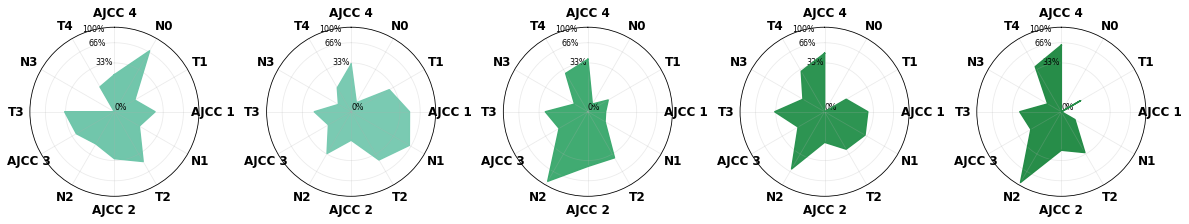

In [246]:
validation_radar(train_data,'ln_cluster',figname='hptesting_outcomes_trainset', textsize=12,whitespace= .4,y_transform = lambda x: np.sqrt(x))

In [101]:
pd.get_dummies(train_data.ln_cluster).describe()

,1.0,2.0,3.0,4.0
count,582.000000,582.000000,582.000000,582.000000
mean,0.762887,0.142612,0.039519,0.049828
std,0.425678,0.349977,0.194994,0.217777
min,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [228]:
def pattern_names(df):
    d = df.copy()
    col_names = get_node_names()
    def getnames(value_array):
        string = ''
        for v,name in zip(value_array, col_names):
            if v == 0:
                continue
            if v == 1:
                string += '1x' + name + '_'
            elif v == 2:
                string += '2x' + name + '_'
        return string[:-1].strip()
    return d.apply(lambda x: getnames(x.values),axis=1)

    
def pattern_summary(df):
    df = df.copy()
    df['pattern'] = pattern_names(df)
    pattern_list = list(df.groupby('pattern').size().sort_values(ascending=False).index[:])
    print(len(pattern_list),'patterns\n')
    total_ft = df.loc[:,'FT'].sum()
    total_as = df.loc[:,'AS'].sum()
    def pattern_details(subset):
        print('count',subset.shape[0])
        subset.loc[:,'FT_percent'] = subset.loc[:,'FT'].values/subset.shape[0] #percent of total toxicity from given pattern
        subset.loc[:,'AS_percent'] = subset.loc[:,'AS'].values/subset.shape[0]
        subset.loc[:,'TOX_percent'] = subset.loc[:,'TOX'].values/subset.shape[0]
        print(subset.loc[:,['FT','FT_percent','AS','AS_percent','TOX','TOX_percent']].sum())
        print()

    for pattern in pattern_list:
        print('pattern',pattern)
        pattern_details(df[df.pattern == pattern])

    print('all_top6')
    pattern_details(df[df.pattern.isin(pattern_list[0:6])])
    
    print('other')
    pattern_details(df[~df.pattern.isin(pattern_list[0:6])])
    
    print('total')
    pattern_details(df)
    
pattern_summary(pdata)

6 patterns

pattern 1x5B
count 351
FT              0.000000
FT_percent      0.000000
AS             11.000000
AS_percent      0.031339
TOX            11.000000
TOX_percent     0.031339
dtype: float64

pattern 
count 303
FT              0.000000
FT_percent      0.000000
AS             63.000000
AS_percent      0.207921
TOX            63.000000
TOX_percent     0.207921
dtype: float64

pattern 2x5B
count 164
FT              0.000000
FT_percent      0.000000
AS             24.000000
AS_percent      0.146341
TOX            24.000000
TOX_percent     0.146341
dtype: float64

pattern 1x6
count 99
FT             99.000000
FT_percent      1.000000
AS             50.000000
AS_percent      0.505051
TOX            99.000000
TOX_percent     1.000000
dtype: float64

pattern 2x5B_1x6
count 33
FT             33.000000
FT_percent      1.000000
AS             16.000000
AS_percent      0.484848
TOX            33.000000
TOX_percent     1.000000
dtype: float64

pattern 1x5B_1x6
count 33
FT             33.00

In [ ]:
def get_pattern_clusters(vectors, k=4, normalize = True, square_dist = True):
#     vectors.loc[:,'bilateral'] = vectors.bilateral.values/2
    if normalize:
        vectors = vectors.loc[:, vectors.std() > 0]
        vectors = (vectors - vectors.mean())/vectors.std()
    patterns = np.unique(vectors.values,axis=0)
    clusterer = AClusterer(k, dist_func = canberra, link = 'ward', square_dist = square_dist)
    temp_clusters = clusterer.fit_predict(patterns)
    mapped_clusters = np.zeros((vectors.shape[0],))
    for p,c in zip(patterns, temp_clusters):
        for v in range(vectors.shape[0]):
            if np.array_equal(vectors.values[v],p):
                mapped_clusters[v] = c
    return pd.DataFrame(mapped_clusters.astype('int32'), index = vectors.index, columns =['cluster'])

def finalized_sorted_clusters(sd):
    clusters = get_pattern_clusters(sd.bigrams())
    clusters = add_outcomes(clusters, sd, nodes=False)
    tox_percent = {}
    for clust,d in clusters.groupby('cluster'):
        tox_percent[clust] = d.loc[:,'TOX'].sum()/d.shape[0]
    clusters['TOX_percent'] = clusters['cluster'].apply(lambda x: tox_percent[x])
    clusters = clusters.sort_values('TOX_percent',axis=0,ascending=True)
    c_num = 1
    c_dict = {}
    for clust,d in clusters.groupby('TOX_percent'):
        old_cluster = d['cluster'].astype('int').mean()
        c_dict[old_cluster] = c_num
        c_num += 1
    return pd.DataFrame(clusters['cluster'].apply(lambda x: c_dict[x]))

# k = 4
# print( get_cluster_correlations( sd, get_pattern_clusters( sd.bigrams(),k=4 ).values.ravel() ) )
# get_cluster_percentages(sd, get_pattern_clusters(sd.bigrams(), k=4))
print( get_cluster_percentages(sd, finalized_sorted_clusters(sd)) )
get_cluster_percentages(sd, get_pattern_clusters(sd.bigrams(), k=4))

In [ ]:
class PatternClusterer():
    
    def __init__(self, train_labels, train_patterns, dist_func = None, linkage = 'average'):
        self.labels = train_labels
        self.patterns = train_patterns
        self.pattern_strings = self.to_pattern_strings(train_patterns)
        self.linkage = linkage
        self.means = train_patterns.mean().values
        self.std = train_patterns.std().values
        self.std[np.argwhere(self.std == 0)] = 1

        self.cluster_vectors = {}
        self.cluster_patterns = {}
        self.cluster_variance = {}
        self.dist_func = canberra if dist_func is None else dist_func
        for c, patterns in self.labels.merge(self.patterns,on='id').groupby('cluster'):
            c_patterns = patterns.drop('cluster',axis=1).drop_duplicates().values
            self.cluster_vectors[c] = c_patterns
            self.cluster_variance[c] = self.df_variance(c_patterns)
            c_pattern_strings = self.to_pattern_strings(c_patterns)
            unique_patterns = set([])
            for cp_string in c_pattern_strings:
                unique_patterns.add(cp_string)
            self.cluster_patterns[c] = unique_patterns
            
    def to_pattern_strings(self, x):
        to_string = lambda k: ''.join(list(k.astype('str')))
        if x.ndim < 2:
            return to_string(x)
        x_strings = np.apply_along_axis(to_string, 1, x)
        return x_strings
    
    def check_existing_patterns(self, p_string):
        for c, patterns in self.cluster_patterns.items():
            if p_string in patterns:
                return c
        return None
    
    def df_variance(self, df, mean_vec = None, euclidean = False):
#         print(df.shape, self.means.shape, self.std.shape)
        df = (df - self.means)/self.std
        if mean_vec is None:
            mean_vec = df.mean()
        diff = []
        for i in range(df.shape[0]):
            v = df[i]
            if euclidean:
                dist = (v - mean_vec)**2
            else:
                dist = self.dist_func(v, mean_vec)
            diff.append(dist)
        return np.sum(diff)
    
    def avg_dist(self, vals, x, dist_func = None):
        if dist_func is None:
            dist_func = self.dist_func
        dist = 0
        n_items = vals.shape[0]
        for i in range(n_items):
            dist += dist_func(vals[i],x)
        return dist/n_items
    
    def cluster_linkage(self, c, x):
        vals = self.cluster_vectors[c]
        if self.linkage == 'ward':
            var = self.df_variance(np.vstack([vals,x]))
            var_change = var - self.cluster_variance[c]
            return var_change
        elif self.linkage == 'euclidean_ward':
            var = self.df_variance(np.vstack([vals,x]), euclidean = True)
            var_change = var - self.cluster_variance[c]
            return var_change
        elif self.linkage == 'average':
            dist = self.avg_dist(vals, x)
            return dist
        elif self.linkage == 'euclidean_average':
            dist = self.avg_dist(vals, x, l2)
            return dist
            
    def closest_cluster(self, x):
        min_dist = np.inf
        curr_cluster = 0
        for c, vals in self.cluster_vectors.items():
            dists = []
            
            dist = self.cluster_linkage(c, x)
            if dist <= min_dist:
                min_dist = dist
                curr_cluster = c
                
        return curr_cluster
        
    def match_cluster(self, p_vector):
        if p_vector.sum() == 0:
            return -1
        
        p_string = self.to_pattern_strings(p_vector)
        already_found = self.check_existing_patterns(p_string)
        if already_found is not None:
            return already_found
        cluster = self.closest_cluster(p_vector)
        self.cluster_patterns[cluster].add(p_string)
        return cluster
    

    
def fit_clusters(sd, vd, output_train_labels = True, linkage = 'average'):
    clusters = finalized_sorted_clusters(sd)
    pattern_clusterer = PatternClusterer(clusters, sd.bigrams(), linkage = linkage)
    
    to_fit = vd.bigrams()
    to_fit['cluster'] = 0
    for pid, row in to_fit.drop('cluster',axis=1).iterrows():
        rowvals = np.array(row)
        cluster_label = pattern_clusterer.match_cluster(rowvals)
        to_fit.loc[pid,'cluster'] = cluster_label
    if output_train_labels:
        cdata = clusters.merge(sd.bigrams(),on='id')
        cdata = pd.concat([cdata,to_fit])
        return cdata[~cdata.index.duplicated()]
    return to_fit

def get_all_clusters(linkage='average'):
    all_clusters = pd.concat([fit_clusters(sd, vd,linkage=linkage), fit_clusters(sd,LNDataset(data_root,validation=True),linkage=linkage)])
    all_clusters = all_clusters[~all_clusters.index.duplicated()]
    return all_clusters

pd.get_dummies(get_all_clusters(linkage='euclidean_average').cluster).sum()

In [ ]:
def drop_duplicate_indices(df):
    df = df.loc[~df.index.duplicated(keep='first')]
    return df 
ht_clusters = drop_duplicate_indices(get_all_clusters(linkage='euclidean_average'))
ht_clusters

In [ ]:
def print_cluster_summaries(clusters,sd):
#     cluster_df = add_outcomes(clusters, sd).merge(sd.dual_monograms, on='id').merge(sd.spread,on='id')
#     for g,d in cluster_df.groupby('cluster'):
#         print('cluster', g, 'count', d.shape[0])
#         print(len(np.unique(d.pattern.values)),'patterns')
#         print(pd.concat([d.loc[:,['AS','FT','TOX']].sum(),d.loc[:,['AS','FT','TOX']].mean()],axis=1))
#         node_names = ['1A','1B','2A','2B','3','4','5A','5B', 'RPLN'] #is is always gone
#         unilateral = (d.loc[:,node_names] == 1).astype('int')
#         bilateral = (d.loc[:,node_names]  > 1).astype('int')
#         either = (d.loc[:,node_names]  > 0).astype('int')
#         spread = d.loc[:,['ips_spread','contra_spread']]
#         print(pd.concat([unilateral.mean(),bilateral.mean(),either.mean(),spread.mean()],axis=1))
#         print()
print_cluster_summaries(ht_clusters, pd.merge(sd.data,vd.data,on='id'))

In [ ]:
from matplotlib.colors import to_hex
import matplotlib.pyplot as plt
def red_hex(val, scale = 1):
    return to_hex(plt.get_cmap('Reds')(val**scale))

def cluster_colors(clusters, sd, scale = .5):
    cluster_df = add_outcomes(clusters, sd).merge(sd.dual_monograms, on='id').merge(sd.spread,on='id')
    cluster_df = cluster_df.merge(sd.dual_bigrams, on='id')
    return cluster_df_colors(cluster_df,scale)

def cluster_df_colors(cluster_df, scale = .5):
    map_list = {}
    for g,d in cluster_df.groupby('cluster'):
        node_names = ['1A','1B','2A','2B','3','4','5A','5B', 'RPLN'] + list(sd.dual_bigrams.columns) #is is always gone
        unilateral = (d.loc[:,node_names] >= 1).astype('int')
        bilateral = (d.loc[:,node_names]  > 1).astype('int')
        df = pd.concat([unilateral.mean(),bilateral.mean()],axis=1)
        map_list[g] =df.applymap(lambda x: red_hex(x, scale))
        
    return map_list
cluster_df_colors(ht_clusters)

In [ ]:
def save_validation_files(save_file = 'validation_clusters', linkages = ['ward','euclidean_ward','average','euclidean_average']):
    save_file += '.csv'
    clusters = get_all_clusters().drop('cluster',axis=1)
    for linkage_option in linkages:
        clusters.insert(0,'cluster_' + linkage_option, get_all_clusters(linkage_option).cluster)
    
    clusters.to_csv(save_file)
    return clusters
save_validation_files()

In [ ]:
def drop_duplicate_indices(df):
    df = df.loc[~df.index.duplicated(keep='first')]
    return df 

test = pd.read_excel('old_ln_patient_data.xlsx', usecols = ['Dummy ID','N-category'])
test = test.set_index('Dummy ID')
test = drop_duplicate_indices(test)
test['N_category_full'] = test['N-category'].apply(lambda x: x if x != 'Nx' else 'N2b')
test = test.drop('N-category',axis=1)
test

In [ ]:
ln_data = pd.read_csv('Anonymized_644.Updated_cleaned_v1.3.2.tsv',sep='\t',engine='python').set_index('Dummy ID')
ln_data = ln_data.merge(test,on='Dummy ID')
# ln_data.to_csv('anonymized_644.csv',index=False)

In [ ]:
sd.data.loc[set(ln_data[ln_data['N-category_y'] == 'Nx']['N-category_y'].index).intersection(sd.data.index)]

In [ ]:
ln_data[ln_data['N_category_full'] == 'N2'].loc[:,['Affected Lymph node UPPER','T-category','HPV/P16 status']]

In [ ]:
ln_data[(ln_data['Affected Lymph node UPPER'] == 'L2') & (ln_data['T-category'] == 'T1')].loc[:,['T-category','HPV/P16 status','N-category','N_category_full']].T

In [ ]:
for i,row in sd.data.iterrows():
    ncat = row['N-category']
    if ncat == 'N2':
        if len(row['nodes']) <= 1:
            ncat = 'N2a'
        else:
            nodestring = ''.join(row['nodes'])
            if 'R' in nodestring and 'L' in nodestring:
                ncat = 'N2c'
            else:
                ncat = 'N2c'
        sd.data.loc[i,'N-category'] = ncat
sd.data[sd.data['N-category'] == 'N2']